In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import ParamTuple

np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

from src.utils.inference.posterior import PosteriorInference

from src.utils.visualization import plot_environment

/home/paul/.local/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### Create Environment

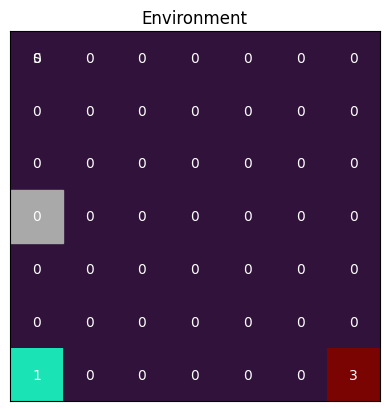

In [3]:
# 0. Setup
## 0.2 Setup the environment
N, M = 7,7

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 1
agent_R[N-1, M-1] = 3



# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.7
p_true=1

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

wall_states = [3*7]
# wall_states.append(1*7+3)
# wall_states.append(1*7+4)
# wall_states.append(1*7+5)
# wall_states.append(0*7+5)

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)

big_small = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_true=agent_R,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

plot_environment(agent_R.reshape(N, M), wall_states)


### Environment Design

In [4]:
env_design = EnvironmentDesign(base_environment=big_small, user_params=true_params, learn_what="gamma, p")

In [5]:
env_design.run_n_episodes(n_episodes=0,
                          bayesian_regret_how=None,
                          candidate_environments_args=None)

env_design.save("big_small")

Started episode 0.
Finished episode 0.


### Inference - load observations and initialize posterior inference class.

In [6]:
import pickle

experiment_name = os.path.join("checkpoints", "big_small", "12.04.2024", "14:05:57")

def load_file(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage
file_name = experiment_name
big_small_experiment = load_file(file_name)

In [7]:
pos_inference = PosteriorInference(expert_trajectories=big_small_experiment["all_observations"],
                                    resolution = 15)

### Calculate Posterior Distribution.

In [8]:
pos_inference.calculate_posterior(num_episodes=1)

Calculate distribution of episode 0, e.g. the prior distribution.
Calculate distribution of episode 1.


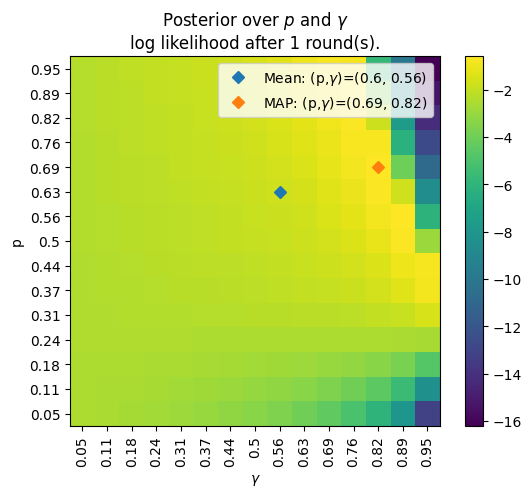

In [9]:
pos_inference.plot_posterior(episode=1)

### Calculate Region of Interest

In [10]:
likelihood = pos_inference.calculate_posterior(episode = 1)

In [18]:
ROI = pos_inference.calculate_region_of_interest(log_likelihood = likelihood)

In [54]:
import numpy as np

n = 0
current_sum = 0
target_sum = 0.8

likelihood_flattened = likelihood.flatten()
sorted_indexes = np.argsort(likelihood_flattened)[::-1]

for i in range(len(sorted_indexes)):
    current_sum += likelihood_flattened[sorted_indexes[i]]
    if current_sum > target_sum:
        n = i + 1
        break

indexes = sorted_indexes[:n]
print(indexes)


[224 209 194  14 179 164 223 208 149  29  13 193 178 134  12 222  28  11  44  27  10 163  26   9  43 207  25   8   7  24  42  23   6  41  22   5  40 119  21
  39   4  20  38   3  37  19  36   2  18  35  59  17  34   1  33  58  16  57  32  56   0  55  31  54  15  53  52  51  30  50  49  48  47  46  45  60  75  61
  90  62 105  76 120  63 135  64 150  91  77 165  65 180 106 195  78  66 210  92 121  67 136  79 107  93 151  68  80 166 122 181  69 108  94 137 196  81 211
 152  70 123  95 109 167  82 138 182 197 124  71  96 153 110  83 212 168 139 183  97 125 111 154  84 198]


In [20]:
ROI.flatten()

array([133, 206, 191, 147, 118, 220, 177, 176, 221, 205, 104,  89, 161, 132, 190, 219, 103, 146, 175, 204, 117, 160, 189, 131, 218, 174, 145, 203,  88, 102,
       116, 159, 188, 130,  74, 217, 173, 144, 202, 101, 158, 115, 187,  87, 129, 148, 216, 172, 143, 201, 192, 157, 114, 186, 100, 128, 215, 171, 142,  86,
       200,  73, 156, 113, 185,  99, 127, 214, 170, 141, 199,  85, 155, 112, 184, 126,  98, 140, 169, 213,  72, 198,  84, 154, 111, 125,  97, 183, 139, 168,
       212,  83, 110, 153,  96,  71, 124, 197, 182, 138,  82, 167, 109,  95, 123,  70, 152, 211,  81, 196, 137,  94, 108,  69, 181, 122, 166,  80,  68, 151,
        93, 107,  79, 136,  67, 121,  92, 210,  66,  78, 195, 106, 180,  65, 165,  77,  91, 150,  64, 135,  63, 120,  76, 105,  62,  90,  61,  75,  60,  45,
        46,  47,  48,  49,  50,  30,  51,  52,  53,  15,  54,  31,  55,   0,  56,  32,  57,  16,  58,  33,   1,  34,  17,  59,  35,  18,   2,  36,  19,  37])

In [46]:
np.argmax(likelihood)

224

In [55]:
# likelihood = np.exp(pos_inference.posterior_distribution["episode=1"])
likelihood = likelihood / np.sum(likelihood)

likelihood

region_of_interest = []
n = 0
current_mass = 0
ROI_mass = 0.8


likelihood_flattened = likelihood.flatten()
sorted_indexes = np.argsort(likelihood_flattened)[::-1]

for i in range(len(sorted_indexes)):
    current_mass += likelihood_flattened[sorted_indexes[i]]
    if current_mass > ROI_mass:
        n = i + 1
        break

#Change to Numpy Array for easier indexing
indexes = sorted_indexes[:n]
indexes


array([224, 209, 194,  14, 179, 164, 223, 208, 149,  29,  13, 193, 178, 134,  12, 222,  28,  11,  44,  27,  10, 163,  26,   9,  43, 207,  25,   8,   7,  24,
        42,  23,   6,  41,  22,   5,  40, 119,  21,  39,   4,  20,  38,   3,  37,  19,  36,   2,  18,  35,  59,  17,  34,   1,  33,  58,  16,  57,  32,  56,
         0,  55,  31,  54,  15,  53,  52,  51,  30,  50,  49,  48,  47,  46,  45,  60,  75,  61,  90,  62, 105,  76, 120,  63, 135,  64, 150,  91,  77, 165,
        65, 180, 106, 195,  78,  66, 210,  92, 121,  67, 136,  79, 107,  93, 151,  68,  80, 166, 122, 181,  69, 108,  94, 137, 196,  81, 211, 152,  70, 123,
        95, 109, 167,  82, 138, 182, 197, 124,  71,  96, 153, 110,  83, 212, 168, 139, 183,  97, 125, 111, 154,  84, 198])

In [ ]:
likelihood.flatten

In [42]:
flat_likelihood_sorted

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0. 

In [14]:
import src.utils.behavior_map as bm

from src.worlds.mdp2d import Experiment_2D

def make_world(
    height: int,
    width: int,
    rewards: np.array,
    absorbing_states: list,
    wall_states: list
) -> Experiment_2D:

    experiment = Experiment_2D(
        height,
        width,
        rewards = rewards,
        absorbing_states = absorbing_states,
        wall_states=wall_states,
    )

    return experiment


custom_world = make_world(height=env_design.base_environment.N,
                          width=env_design.base_environment.M,
                          rewards=env_design.base_environment.R_true,
                          absorbing_states=env_design.base_environment.goal_states,
                          wall_states=env_design.base_environment.wall_states)

In [15]:
probs = np.linspace(0.5, 0.95, 15)
gammas = np.linspace(0.5, 0.95, 15)

out = bm.plot_bmap(
    world=custom_world,
    gammas=gammas,
    probs=probs
)

## Behavior Map Entropy Learning

In [16]:
probs = np.linspace(0.5, 0.95, 15)
gammas = np.linspace(0.5, 0.95, 15)

In [17]:
from src.utils.make_candidate_environments import EntropyBM

_param_estimates = pos_inference.MAP(episode=1)

T_estimate = transition_matrix(N, M, p=_param_estimates.p, absorbing_states=goal_states)
T_estimate = insert_walls_into_T(T=T_estimate, wall_indices=wall_states)

param_estimates = ParamTuple(p = T_estimate, gamma=_param_estimates.gamma, R = agent_R)

ent_bm = EntropyBM(parameter_estimates=param_estimates, gammas=gammas, probs=probs, region_of_interest=region_of_interest)
perturbed_reward = ent_bm.BM_search(world = custom_world, n_compute_BM=5)

AssertionError: Posterior Distribution for this episode does not exist yet. Only the following episodes exist: dict_keys([])

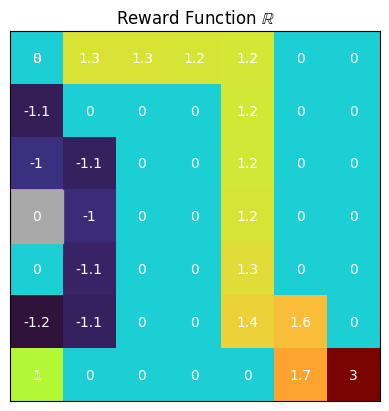

In [ ]:
plot_environment(reward_function=perturbed_reward.reshape(N, M), wall_states=wall_states, title=r"Reward Function $\mathbb{R}$")


In [ ]:
ent_bm.compute_covers(out)

({0: 0.7377777777777778, 1: 0.26222222222222225}, 0.5)

### Calculate Behavior Map

In [ ]:
import src.utils.behavior_map as bm

from src.worlds.mdp2d import Experiment_2D

def make_world(
    height: int,
    width: int,
    rewards: np.array,
    absorbing_states: list,
    wall_states: list
) -> Experiment_2D:

    experiment = Experiment_2D(
        height,
        width,
        rewards = rewards,
        absorbing_states = absorbing_states,
        wall_states=wall_states,
    )

    return experiment


custom_world = make_world(height=env_design.base_environment.N,
                          width=env_design.base_environment.M,
                          rewards=env_design.base_environment.R_true,
                          absorbing_states=env_design.base_environment.goal_states,
                          wall_states=env_design.base_environment.wall_states)

In [ ]:
probs = np.linspace(0.3, 0.95, 15)
gammas = np.linspace(0.5, 0.95, 15)

out = bm.plot_bmap(
    world=custom_world,
    gammas=gammas,
    probs=probs
)

In [ ]:
# from copy import deepcopy
# import matplotlib.pyplot as plt


# class AgnosticsBM():

#     def __init__(self, 
#                  environment,
#                  behavior_map_environment,
#                  region_of_interest=None):
        
#         self.environment = environment
#         self.perturbed_environment = deepcopy(self.environment)
#         self.region_of_interest  = region_of_interest
#         self.behavior_map_base_environment = behavior_map_environment
#         self.behavior_map_perturbed_environment = None
#         self.prop_dominant_policy = []
#         self.prop_subdominant_policy = []
#         self.prop_unreasonable_policy = []
#         self.perturbed_environments = {}
#         self.perturbed_behavior_maps = {}
#         self.n_accepted = 0

#     def calculate_behavior_map_stats(self, behavior_map):

#         '''
#         Determine reasonable, unreasonable and dominant policies in the behavior map.
#         '''

#         #Reasonable policies are all policies that don't stay in the start state. Unreasonable policies stay in the start state.
#         reasonable_policies_idx = [p for p, states in behavior_map.pidx2states.items() if states[-1] in self.environment.goal_states]
#         unreasonable_policies_idx = [p for p, states in behavior_map.pidx2states.items() if states[-1] not in self.environment.goal_states]

#         #Number of different policies.
#         behaviors_flattened = behavior_map.data.flatten()
#         #Only get behaviors in Region of interest.
#         if self.region_of_interest is not None:
            
#             behaviors_flattened = behavior_map.data[tuple(self.region_of_interest.T)]
#         n_behaviors = len(behaviors_flattened)

#         if self.region_of_interest is not None:
#             assert n_behaviors == self.region_of_interest.shape[0], "The number of behaviors in the region of interest does not match the number of behaviors in the behavior map."

#         #Number of reasonable policies.
#         n_reasonable_behaviors = np.sum(np.isin(behaviors_flattened, reasonable_policies_idx))
#         n_unreasonable_behaviors = np.sum(np.isin(behaviors_flattened, unreasonable_policies_idx))

#         #Count the number of times each policy is chosen.
#         behavior, counts = np.unique(behaviors_flattened, return_counts=True)
#         behavior_counts = dict(zip(behavior, counts))

#         #Dominant policy is the policy with the most counts, e.g. that covers the largest proportion of the Behavior Map.
#         # Remove all unreasonable policies from the counts.
#         for unreasonable_policy in unreasonable_policies_idx:
#             behavior_counts.pop(unreasonable_policy, None)

#         #Get the dominant policy. If there are only unreasonable policies (e.g. behavior counts ie empty), then the dominant policy is None.
#         if behavior_counts == {}:
#             dominant_policy = None
#             return 0, 0, 1, None
#         else:
#             dominant_policy = max(behavior_counts, key=behavior_counts.get)

#         #Subdominant policies are all policies that are a) not dominant and b) not unreasonable.
#         n_dominant_behaviors = behavior_counts[dominant_policy]
#         n_subdominant_behaviors = n_reasonable_behaviors - n_dominant_behaviors

#         #Determine proportion of BM that each policy type covers.
#         prop_dominant_policy = n_dominant_behaviors / n_behaviors
#         prop_subdominant_policy = n_subdominant_behaviors / n_behaviors
#         prop_unreasonable_policy = n_unreasonable_behaviors / n_behaviors

#         #Get a rollout of the dominant policy.
#         dominant_states = behavior_map.pidx2states[dominant_policy]

#         return prop_dominant_policy, prop_subdominant_policy, prop_unreasonable_policy, dominant_states

#     def perturb_transition_dynamics(self, states):

#         '''
#         We want to change the transition dynamics, such that prop_dominant_policy decreases and prop_subdominant_policy increases while prop
#         _unreasonable_policy remains small.
#         We can do this by changing the reward function and transition dynamics such that the dominant policy becomes less attractive and the subdominant
#         poicies become more attractive. To this end, we insert walls/ death states along the rollouts of the dominant policy and remove walls/death states
#         from the rollouts of the subdominant policies. This will make the dominant policy less attractive and the subdominant policies more attractive.
#         '''
#         #Get a random state from the dominant policy to insert a wall into. Remove goal states and start state.
#         random_state_from_dominant = np.random.choice(list(states), size = 1)
#         random_state_from_dominant = np.setdiff1d(random_state_from_dominant, env_design.base_environment.goal_states)
#         #TODO: start state should be flexible, not 0.
#         random_state_from_dominant = np.setdiff1d(random_state_from_dominant, [0])

#         #Insert walls into the transition matrix along the rollouts of the dominant policy and update transition function.
#         T_new = insert_walls_into_T(T=self.perturbed_environment.T_true, wall_indices=random_state_from_dominant)
#         self.perturbed_environment.wall_states = np.append(self.perturbed_environment.wall_states, random_state_from_dominant)
#         self.perturbed_environment.T_true = T_new
#         print(f"Perturbed transition dynamics. Inserted a wall into state {random_state_from_dominant}.")

    
#     def perturb_reward_function(self, states):

#         '''
#         Change reward function along dominant rollout of dominant.
#         '''
#         #Get a random state from the dominant policy to insert a wall into. Remove goal states and start state.
#         random_state_from_dominant = np.random.choice(list(states), size = 1)
#         random_state_from_dominant = np.setdiff1d(random_state_from_dominant, env_design.base_environment.goal_states)
#         #TODO: start state should be flexible, not 0.
#         random_state_from_dominant = np.setdiff1d(random_state_from_dominant, [0])
#         #Insert negative reward into the transition matrix along the rollouts of the dominant policy.
#         R_new = self.perturbed_environment.R_true.copy()
#         R_new[random_state_from_dominant] += -0.1

#         self.perturbed_environment.R_true = R_new
#         print(f"Perturbed reward function. Inserted a negative reward into state {random_state_from_dominant}.")

    
#     def perturb_environment(self, n_iterations: int,
#                             plot_bmap: bool = False,):

#         '''
#         Perturb the environment such that the dominant policy becomes less attractive and the subdominant policies become more attractive.
#         '''

#         #Statistics of Base Environment.
#         prop_dominant_policy, prop_subdominant_policy, prop_unreasonable_policy, dominant_states = self.calculate_behavior_map_stats(behavior_map=self.behavior_map_base_environment)
#         self.prop_dominant_policy.append(prop_dominant_policy)
#         self.prop_subdominant_policy.append(prop_subdominant_policy)
#         self.prop_unreasonable_policy.append(prop_unreasonable_policy)

#         prev_prop_dominant_policy = prop_dominant_policy
#         prev_prop_subdominant_policy = prop_subdominant_policy
#         prev_prop_unreasonable_policy = prop_unreasonable_policy

        
#         for iteration in range(n_iterations):

#             #Calculate statistics of current behavior map, e.g. what is the dominant policy, how much of the Behavior Map is covered
#             #by the dominant policy, how much of the Behavior Map is covered by unreasonable policies.

#             #Perturb the reward function.
#             self.perturb_reward_function(dominant_states)

#             #Perturb the transition function. Only insert wall 30% of the time.
#             theta = np.random.uniform(0, 1)
#             if theta < 0.3:
#                 self.perturb_transition_dynamics(dominant_states)

#             #Generate new Behavior Map.
#             behavior_map_perturbed_environment = self.generate_behavior_map(plot_bmap=plot_bmap)

#             #Calculate statistics of new behavior map.
#             prop_dominant_policy, prop_subdominant_policy, prop_unreasonable_policy, dominant_states = self.calculate_behavior_map_stats(
#                                                                                                         behavior_map=behavior_map_perturbed_environment)

#             if (prop_subdominant_policy - prop_dominant_policy)/prop_unreasonable_policy > (prev_prop_subdominant_policy - prev_prop_dominant_policy)/prev_prop_unreasonable_policy:
#                 #Accept this environment.

#                 #Append statistics to list.
#                 print("Accepted Environment.")
#                 self.prop_dominant_policy.append(prop_dominant_policy)
#                 self.prop_subdominant_policy.append(prop_subdominant_policy)
#                 self.prop_unreasonable_policy.append(prop_unreasonable_policy)

#                 #Store perturbed environment.
#                 self.perturbed_environments[f"iteration_{iteration}"] = self.perturbed_environment
#                 self.perturbed_behavior_maps[f"iteration_{iteration}"] = behavior_map_perturbed_environment

#                 #Update previous statistics.
#                 prev_prop_dominant_policy = prop_dominant_policy
#                 prev_prop_subdominant_policy = prop_subdominant_policy
#                 prev_prop_unreasonable_policy = prop_unreasonable_policy

#                 self.n_accepted += 1

#             else:
#                 #Reject this environment. Reset the environment to the previous environment.
#                 print("Rejected Environment.")
#                 pass

#             if prop_dominant_policy == 0:
#                 print(f"Terminating perturbation. Dominant policy has been removed.")
#                 break


#     def generate_behavior_map(self,
#                               plot_bmap: bool = False):

#         '''
#         Calculate the behavior map.
#         '''

#         self.world = make_world(height=self.perturbed_environment.N,
#                           width=self.perturbed_environment.M,
#                           rewards=self.perturbed_environment.R_true,
#                           absorbing_states=self.perturbed_environment.goal_states,
#                           wall_states=self.perturbed_environment.wall_states)

#         behavior_map_perturbed_environment = bm.plot_bmap(
#             world=self.world,
#             gammas=gammas,
#             probs=probs,
#             plot=plot_bmap
#         )

#         return behavior_map_perturbed_environment

    
#     def plot_behavior_map(self, environment, gammas, probs):

#         '''
#         Plot the behavior map of an environment for parameter bounds gammas and probs.
#         '''

#         self.world = make_world(height=environment.N,
#                           width=environment.M,
#                           rewards=environment.R_true,
#                           absorbing_states=environment.goal_states,
#                           wall_states=environment.wall_states)

#         self.behavior_map_perturbed_environment = bm.plot_bmap(
#             world=self.world,
#             gammas=gammas,
#             probs=probs,
#             plot=True
#         )

#     def plot_props_over_time(self, iteration=None):

#         '''
#         Plot the proportion of the Behavior Map covered by the dominant policy, subdominant policy and unreasonable policy over time.

#         Args:
#         iteration: int, the iteration to plot the proportion of the Behavior Map covered by the dominant policy, subdominant policy and unreasonable policy up to.
#         if none: plot all iterations.
#         '''

#         if iteration is None:
#             iteration = len(self.prop_dominant_policy)-1
            
#         _iterations = np.arange(0, iteration+1, 1.0)
#         plt.plot(_iterations, self.prop_dominant_policy[:iteration+1], "x-", color="green", label="Dominant Policy")
#         plt.plot(_iterations, self.prop_subdominant_policy[:iteration+1], "o-", color="red", label="Subdominant Policies")
#         plt.plot(_iterations, self.prop_unreasonable_policy[:iteration+1], "s-", color="blue", label="Unreasonable Policy")
#         plt.xlabel("Iteration")
#         plt.ylabel("Proportion of Behavior Map")
#         plt.legend()
#         plt.title("Proportion of BM covered by Dominant, Subdominant and Unreasonable Policies.")
#         plt.xticks(_iterations)
#         plt.show()

#         del _iterations

In [ ]:
# agnostics_bm = AgnosticsBM(environment=env_design.base_environment,behavior_map_environment=out, region_of_interest=region_of_interest)

In [ ]:
# n_iterations=25
# agnostics_bm.perturb_environment(n_iterations=n_iterations, plot_bmap=False)

Perturbed reward function. Inserted a negative reward into state [29].


/tmp/ipykernel_5817/3025296761.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  if (prop_subdominant_policy - prop_dominant_policy)/prop_unreasonable_policy > (prev_prop_subdominant_policy - prev_prop_dominant_policy)/prev_prop_unreasonable_policy:


Accepted Environment.
Perturbed reward function. Inserted a negative reward into state [].
Rejected Environment.
Perturbed reward function. Inserted a negative reward into state [22].
Accepted Environment.
Perturbed reward function. Inserted a negative reward into state [2].
Rejected Environment.
Perturbed reward function. Inserted a negative reward into state [].
Perturbed transition dynamics. Inserted a wall into state [14].
Rejected Environment.
Perturbed reward function. Inserted a negative reward into state [36].
Rejected Environment.
Perturbed reward function. Inserted a negative reward into state [43].
Rejected Environment.
Perturbed reward function. Inserted a negative reward into state [8].
Perturbed transition dynamics. Inserted a wall into state [].
Rejected Environment.
Perturbed reward function. Inserted a negative reward into state [28].
Rejected Environment.
Perturbed reward function. Inserted a negative reward into state [15].


SystemError: CPUDispatcher(<function value_iteration_with_policy at 0x7202d6206440>) returned a result with an exception set

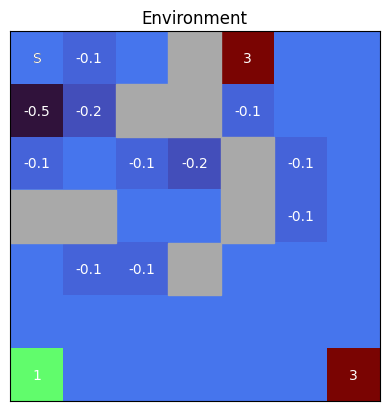

In [ ]:
plot_environment(agnostics_bm.perturbed_environments["iteration_16"].R_true.reshape(N,M), agnostics_bm.perturbed_environments["iteration_16"].wall_states)

In [ ]:
agnostics_bm.perturbed_environments

{'iteration_3': <src.utils.make_environment.Environment at 0x7ff163f93220>,
 'iteration_4': <src.utils.make_environment.Environment at 0x7ff163f93220>,
 'iteration_5': <src.utils.make_environment.Environment at 0x7ff163f93220>,
 'iteration_6': <src.utils.make_environment.Environment at 0x7ff163f93220>,
 'iteration_8': <src.utils.make_environment.Environment at 0x7ff163f93220>,
 'iteration_9': <src.utils.make_environment.Environment at 0x7ff163f93220>,
 'iteration_10': <src.utils.make_environment.Environment at 0x7ff163f93220>,
 'iteration_14': <src.utils.make_environment.Environment at 0x7ff163f93220>,
 'iteration_16': <src.utils.make_environment.Environment at 0x7ff163f93220>,
 'iteration_18': <src.utils.make_environment.Environment at 0x7ff163f93220>}

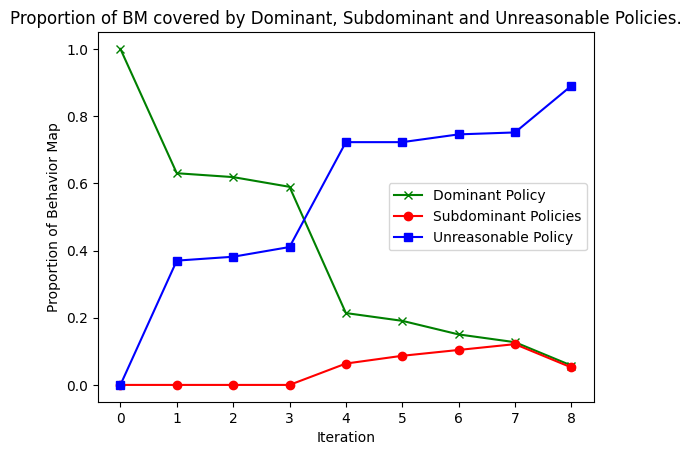

In [ ]:
agnostics_bm.plot_props_over_time()